In [3]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle as pkl
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from notebook_utils import *
from parameter_estimation import load_data_util
import numpy as np
import pandas as pd
import snap
import operator
# import seaborn as sns
from scipy import stats
%matplotlib inline
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif', size='15') # controls default text sizes
plt.rc('xtick', labelsize='15')
plt.rc('ytick', labelsize='15')
plt.rc('legend', fontsize='15') # legend fontsize
plt.rc('axes', labelsize='15', titlesize='15', linewidth=1.1)  # fontsize of the x and y labels # fontsize of the axes title
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Introduction Plot of Examples from Dataset

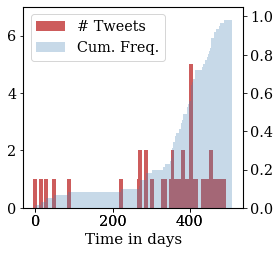

In [15]:
from datetime import datetime
import time, datetime
import numpy as np

# ulist = list(); tlist = list()
# for line in open("./Tweets/R_SwinePork.txt"):
#     u = line.split()[0]
#     #print line.strip().split("\t")[-1]
#     t = datetime.strptime(line.strip().split("\t")[-1], '%Y-%m-%d %H:%M:%S')
#     ulist.append(u)
#     tlist.append(t)
# print ulist[0:2]
# print tlist[0:2]

# f = open("/meladyfs/newyork/krsharma/kdd_data/kwon/Tweets/N_Airliner.txt")
f = open("/meladyfs/newyork/krsharma/kdd_data/kwon/Tweets/R_MentosCokeDeath.txt")
ulist, tslist = list(), list()
for line in f.readlines():
    # print(line.split("\t")[-1])
    # uid, timestamp = line.split("\t")[0], int(line.split("\t")[-1]) # time.mktime(datetime.datetime.strptime(line.split("\t")[-1].rstrip(), '%Y-%m-%d %H:%M:%S').timetuple()) # ma
    uid, timestamp = line.split("\t")[0], time.mktime(datetime.datetime.strptime(line.split("\t")[-1].rstrip(), '%Y-%m-%d %H:%M:%S').timetuple()) # kwon
    # uid, timestamp = line.split("\t")[0],  mktime_tz(parsedate_tz(line.split("\t")[-1].rstrip()))
    # time.mktime(datetime.datetime.strptime(line.split("\t")[-1].rstrip(), '%a %b %d %H:%M:%S %z %Y').timetuple()) # pheme
#     print uid, timestamp
#     break
    ulist.append(uid)
    tslist.append(timestamp)
tslist, ulist = zip(*sorted(zip(tslist, ulist)))
rel_tslist = np.array(tslist) - np.array(tslist[0])
f.close()

# print ulist # [0:2]
# print rel_tslist/3600/24 # [0:2]
# print len(ulist)

# ----------------------
i_cumulative = []
cutoff = 1000000
lag = 24

i_in_period = 0;
hour = lag

for uname, timestamp in zip(ulist, rel_tslist):
    # print uname, timestamp
    timestamp = float(timestamp)/3600.0
    if timestamp > cutoff and len(i_cumulative) >= 30: 
        print("breaking")
        break
    if timestamp > hour:
        counter = timestamp / lag - len(i_cumulative) 
        # if counter > 100: counter=100
        for c in range(int(counter)):
            i_cumulative.append(i_in_period)
            hour += lag
            i_in_period = 0
        # print "adding", counter
    i_in_period += 1
    # if len(i_cumulative) > 1000: break
# print i_cumulative, len(i_cumulative)

# ----------------------

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%matplotlib inline

fig1 = plt.figure(figsize=(4, 4))
ax1 = fig1.add_subplot(111)
# and the first axes using subplot populated with data 
line1 = plt.bar(np.arange(len(i_cumulative)), i_cumulative, width=10.0, color='indianred')

ax1.set_ylim(0, max(i_cumulative)+2)
# ax1.yaxis.tick_left()
# ax1.legend(fontsize=12)
    
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
cdf = np.cumsum(i_cumulative)*1.0/len(ulist)
line2 = ax2.bar(range(len(i_cumulative)), cdf, width=1.0, alpha=0.3, color='steelblue', linewidth=1.0)
ax2.set_ylim(0, 1+0.05)
ax2.yaxis.tick_right()
# ax2.legend(fontsize=12, loc='upper right')


plt.legend((line1, line2), ('# Tweets', 'Cum. Freq.'), loc='upper left')

plt.xlabel('Time in days', fontsize=15)
plt.tight_layout()

# plt.savefig('newfake_mentoscoke.pdf', bbox_inches='tight')
# plt.savefig('newtrue_airliner.pdf', bbox_inches='tight')

# np.savetxt("y_fake", i_cumulative)
plt.show()

# Distribution Empirical: Engagements Per User

In [18]:
data='tma'
data_dir = "../data/{}/".format(data)
cascades_file = data_dir + 'cascades.txt'
labels_file = data_dir + 'labels.txt'

train_cascades = read_cascades_file(cascades_file)
train_labels = np.loadtxt(labels_file)
print('num cascades', len(train_cascades), len(train_labels))

def eng_count():
    true_cascades = np.array(train_cascades)[train_labels==0]
    fake_cascades = np.array(train_cascades)[train_labels == 1]
    # print('t/f', len(true_cascades), len(fake_cascades))

    u_t, u_f, sorted_t, sorted_f = get_engagement_counts(true_cascades, fake_cascades)
    print('u_t, u_f, tot', len(u_t), len(u_f), len(u_t) + len(u_f))
    sorted_users = np.concatenate([sorted_t, sorted_f], axis=0)
    # users with engagements greater than 5
    num_users_with_large_eng = len(sorted_users[sorted_users[:, 1] > 5])
    print('users large eng > 5', num_users_with_large_eng)
    num_users_with_large_eng = len(sorted_users[sorted_users[:, 1] > 10])
    print('users large eng > 10', num_users_with_large_eng)
    num_users_with_large_eng = len(sorted_users[sorted_users[:, 1] > 50])
    print('users large eng > 50', num_users_with_large_eng)
    
    return u_t, u_f

u_t, u_f = eng_count()


num cascades 992 992
u_t, u_f, tot 180902 81774 262676
users large eng > 5 16064
users large eng > 10 7174
users large eng > 50 557


In [13]:
cascade_lens = [len(cas) for cas in train_cascades]

992 992
494 498
[756 618 542 ...   1   1   1]
[365 334 332 ...   1   1   1]


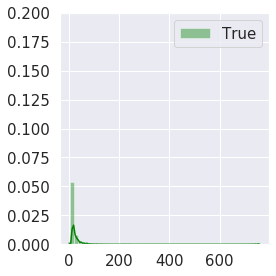

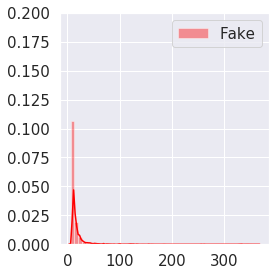

In [4]:

import numpy as np

train_labels = np.loadtxt("../data/tma/labels.txt")
# train_labels = np.loadtxt("../../datasets/kwon/labels.txt")
def _read_cascades_file(cascades_filename):
    """
    Returns
    -------
    cascades : list(np.array((None, 2)))
        list of user_str, timestamp array (one array per cascade)
    """
    f = open(cascades_filename, "r")
    cascades = []
    for line in f.readlines():
        u_t = line.strip("\n").split(",")
        u = list(map(str, u_t[0::2]))  # string
        t = list(map(float, u_t[1::2]))  # float
        cascade = np.vstack([u, t]).transpose()
        cascades.append(cascade)
    f.close()
    return cascades
# train_cascades = _read_cascades_file("../../datasets/kwon/cascades.txt")
train_cascades = _read_cascades_file("../data/tma/cascades.txt")
print(len(train_cascades), len(train_labels))

true_cascades = np.array(train_cascades)[train_labels==0]
fake_cascades = np.array(train_cascades)[train_labels == 1]
print(len(true_cascades), len(fake_cascades))

# -------------------------------

# TRUE AND FAKE - distribution of engagement counts [Top 2K users]
import operator
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


u_t = {}
for cas in true_cascades:
    for u in cas[:,0]:
        if u in u_t: u_t[u] += 1
        else: u_t[u] = 1
sorted_t = np.array(sorted(u_t.items(), key=operator.itemgetter(1), reverse=True), dtype=np.int32)

u_f = {}
for cas in fake_cascades:
    for u in cas[:,0]:
        if u in u_f: u_f[u] += 1
        else: u_f[u] = 1
sorted_f = np.array(sorted(u_f.items(), key=operator.itemgetter(1), reverse=True), dtype=np.int32)

# COMMENTED PLOT
# print(sorted_t[0:10])
# print(np.sum(sorted_f[:, 1] == 1))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=False)
t = sorted_t[1:, 1]  # kwon  = sorted_t[:, 1]
f = sorted_f[:, 1]

print(t)
print(f)

t1 = t[t>5]
f1 = f[f>5]

t2 = t1[t1<1000]  # Kwon t2 = t1
f2 = f1[f1<1000]  # kwon f2 = f1

plt.figure(figsize=(4,4))

sns.distplot(t2, color="green", label="True");

plt.legend(loc='upper right', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 0.2) # KWON = 0.12
# plt.xlim(-100, 800) ADD BACK IN KWON
plt.tight_layout()
# plt.savefig('kde_dist_tma_true.png')

plt.figure(figsize=(4,4))

sns.distplot(f2, color="red", label="Fake");
plt.legend(loc='upper right', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 0.2)  # KWON = 0.12
# plt.xlim(-100, 800) ADD BACK IN KWON

plt.tight_layout()
# plt.savefig('kde_dist_tma_fake.png')


# Kwon Dataset: Extract retweet links from follows links.txt (prune)

In [17]:
# find number of connected components in cascade by retweet graph created by follows network

cascades_file = "../data/kwon/cascades.txt"
links_file = "/home/krsharma/workspace/code_base_unfinished/mic_kdd/kdd_netinference/kwon/links.txt"

import numpy as np
all_cas_users = set()
cas_users = []
f = open(cascades_file, 'r')
for line in f.readlines():
    # print(line)
    cas_users = np.array(line.split(',')[::2], dtype=np.int64)
    # print(cas_users)
    all_cas_users.update(set(cas_users))
    # break
print("done")

print(len(all_cas_users))

import pandas as pd

list_df = []
total_edges = 0
chunksize = 10 ** 6
for i, chunk in enumerate(pd.read_csv(links_file, chunksize=chunksize, header=None, sep=' ')):
    # print(chunk)
    df = chunk[chunk[0].isin(cas_users) & chunk[1].isin(cas_users)]
    print("i", "len", i, len(df))
    total_edges += len(df)
    list_df.append(df)
    # break
print("total=", total_edges)
# df = pd.read_csv(links_file, header = 4)
# print(df)
# print('ok')

edges_df = pd.concat(list_df)
print(len(edges_df))

print(edges_df.head())

edges_df.to_csv('../data/kwon/rel_links.txt', sep=' ', header=None, index=False)


done
117824
i len 0 300
i len 1 142
i len 2 140
i len 3 128
i len 4 164
i len 5 122
i len 6 34
i len 7 102
i len 8 96
i len 9 148
i len 10 108
i len 11 212
i len 12 116
i len 13 400
i len 14 112
i len 15 124
i len 16 250
i len 17 304
i len 18 156
i len 19 154
i len 20 148
i len 21 242
i len 22 182
i len 23 194
i len 24 106
i len 25 180
i len 26 298
i len 27 158
i len 28 120
i len 29 158
i len 30 22
i len 31 114
i len 32 146
i len 33 140
i len 34 184
i len 35 266
i len 36 190
i len 37 222
i len 38 118
i len 39 82
i len 40 310
i len 41 252
i len 42 176
i len 43 150
i len 44 140
i len 45 168
i len 46 110
i len 47 138
i len 48 148
i len 49 164
i len 50 100
i len 51 360
i len 52 192
i len 53 222
i len 54 112
i len 55 148
i len 56 240
i len 57 76
i len 58 88
i len 59 174
i len 60 212
i len 61 94
i len 62 138
i len 63 128
i len 64 266
i len 65 144
i len 66 206
i len 67 176
i len 68 78
i len 69 242
i len 70 246
i len 71 180
i len 72 100
i len 73 156
i len 74 74
i len 75 152
i len 76 462
i len 

In [ ]:
links_file = "../data/kwon/rel_links.txt"
import networkx as nx
import pandas as pd
import numpy as np

df = pd.read_csv(links_file, header=None, sep=' ')

node_set = set(df[0])
node_set.update(set(df[1]))
dict_nodes = dict(zip(node_set, np.arange(len(node_set))))

df_idx = pd.DataFrame()
df_idx[0] = df[0].apply(lambda x: dict_nodes[x])
df_idx[1] = df[1].apply(lambda x: dict_nodes[x])


list_e = []
for i, row in df_idx.iterrows():
    e = (row[0], row[1])
    list_e.append(e)
print(list_e)
# G=nx.read_edgelist(links_file)
# print(nx.number_connected_components(G))

In [41]:
# A(0) follows B(1)
G = nx.DiGraph()
G.add_nodes_from(np.arange(len(node_set)))
G.add_edges_from(list_e)

In [73]:
indeg = []
for d in G.out_degree():
    indeg.append(d[1])
# indeg

In [74]:
np.mean(indeg), np.max(indeg), np.median(indeg)

(6.548371873525248, 126, 3.0)

In [84]:
nx.number_strongly_connected_components(G)


810

In [ ]:
(6.548371873525248, 137, 2.0)

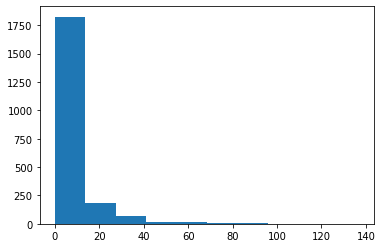

In [53]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_degree_dist(G):
    degrees = indeg # [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()
    
plot_degree_dist(G)

In [35]:
# edges
len(df)

27751

# P-Value: Ratio of Connected Components

In [2]:
cascades_file = "../data/kwon/cascades.txt"
links_file = "../data/kwon/rel_links.txt"
labels_file = "../data/kwon/labels.txt"

import numpy as np
all_cas_users = set()
list_cas = []
f = open(cascades_file, 'r')
for i, line in enumerate(f.readlines()):
    #print(line)
    cas_times = np.array(line.split(',')[1::2], dtype=np.float32)
    cas_users = np.array(line.split(',')[::2], dtype=np.int64)
    list_cas.append((cas_users, cas_times))
    all_cas_users.update(set(cas_users))
#     if i == 3:
#         break
print("done", len(all_cas_users))

import pandas as pd
df = pd.read_csv(links_file, sep=' ', header=None)

print(df.head()) # 0 follows 1
print(len(df))
# source -> tweets -> A comments (A follows source)
# info diffusion from source to A. (p_sA > 0)
# directed edge from s to A.

# A follows S
# Then S->A edge in graph if time(S) < time(A)
# A follows B
# Then B->A edge in graph if time(B) < time(A)
# Between S and B, keep one with later timestep.
#     S A B
# S     1
# A
# B     1
# each col should have at most 1 one. keep latest timestep

# construct retweet graph for each cascade from follow links (time take last one as parent)
import networkx as nx 

def get_graph_cc(links, casu, cast):
    # get times
    time_dict = {} # uid -> time
    for u, t in zip(casu, cast):
        time_dict[u] = t
    
    linked_user_dict_ = {} # uid -> index
    list_linked_user = [] # list of indexed uid
    next_user = 0
    for index, row in links.iterrows():
        u, v = row[0], row[1]
        if u not in linked_user_dict_:
            linked_user_dict_[u] = next_user
            list_linked_user.append(u)
            next_user += 1
        if v not in linked_user_dict_:
            linked_user_dict_[v] = next_user
            list_linked_user.append(v)
            next_user += 1
    set_linked_u = set(linked_user_dict_.keys())
    isolated_u = set(casu) - set_linked_u
    # print("isolated", len(isolated_u), len(casu))
    
    total_linked_users = len(linked_user_dict_)
    mat = np.zeros((total_linked_users, total_linked_users))
    for index, row in links.iterrows():
        u, v = row[0], row[1]
        if time_dict[v] < time_dict[u]:
            mat[linked_user_dict_[v], linked_user_dict_[u]] = 1
    # print(mat)
    
    time_col = np.zeros((total_linked_users))
    for i, user in enumerate(list_linked_user):
        time_col[i] = time_dict[user]    
    
    for colno in range(len(mat)):
        col = mat[:, colno]
        if col.sum() > 1:
            ind = np.argmax(col)
            mat[:, colno] = 0
            mat[ind, colno] = 1
    num_cc = len(isolated_u)
    
    G = nx.from_numpy_matrix(mat, create_using=nx.DiGraph())
    cc = nx.weakly_connected_components(G)
    a = [len(c) for c in sorted(cc, key=len, reverse=True)]
    # print(a)
    num_cc += len(a)
    return num_cc

num_cc = []
cas_size = []
for cas in list_cas:
    casu, cast = cas[0], cas[1]
    links = df[df[0].isin(casu) & df[1].isin(casu)]
    cas_size.append(len(casu))
    if len(links) == 0:
        num_cc.append(len(casu))
    else:
        num_cc.append(get_graph_cc(links, casu, cast))
print(num_cc)
print(cas_size)

labels = np.loadtxt(labels_file)
fake_ind = np.where(labels==1)[0]
true_ind = np.where(labels==0)[0]
number_cc = np.array(num_cc, dtype=np.float32)
cascade_size = np.array(cas_size, dtype=np.float32)
prop_cc = number_cc / cascade_size
# print(prop_cc)

print(prop_cc[fake_ind])
print("\n")
print(prop_cc[true_ind])


a = prop_cc[fake_ind]
b = prop_cc[true_ind]
print(",".join(map(str, a)))
print(",".join(map(str, b)))
# The z-score is 1.87577. The p-value is .03005. The result is significant at p < .05.

# -----------------------------

y = np.sort(prop_cc)[:24] # removing multiple 1.0s

d = {}
for i, yi in enumerate(y):
    d[yi] = i
    
F_fake = np.zeros((len(y)))
for item in sorted(prop_cc[fake_ind]):
    # print(item)
    loc_in_y = d[item]
    F_fake[loc_in_y:]+=1
F_f = F_fake/len(fake_ind)

F_true = np.zeros((len(y)))
for item in sorted(prop_cc[true_ind]):
    # print(item)
    loc_in_y = d[item]
    F_true[loc_in_y:]+=1
F_t = F_true/len(true_ind)

print(F_f)
print(F_t)
sample_size_fake = len(fake_ind)
sample_size_true = len(true_ind)
print(sample_size_fake)
print(sample_size_true)

D_crit = 1.07 * np.sqrt(1.0/sample_size_fake + 1.0/sample_size_true)
print("crit", D_crit)

max_val = 0
for i, yi in enumerate(y):
    o = np.abs(F_f[i] - F_t[i])
    if o > max_val:
        max_val = o
print("Dn", max_val)

# -----------------------------



done 117824
         0       1
0   287228  132630
1   287228  132630
2  8213456  132630
3  8213456  132630
4  9019791  132630
27752
[125, 604, 225, 131, 22, 505, 628, 846, 10, 372, 718, 240, 469, 653, 477, 24, 129, 1006, 42, 1154, 13, 262, 1439, 342, 41, 123, 507, 517, 369, 3503, 19, 9701, 41, 1278, 77, 8270, 14, 102, 282, 145, 151, 916, 767, 116, 2715, 4028, 113, 51, 222, 9786, 930, 81, 1519, 783, 12345, 4041, 120, 59, 3054, 131, 25, 304, 116, 579, 162, 414, 121, 14, 56, 48, 2511, 47, 231, 233, 2148, 3866, 1040, 302, 59, 20, 875, 7592, 543, 315, 112, 39, 21573, 36, 152, 2849, 103, 17, 15, 1143, 159, 7345, 98, 1872, 3585, 58, 95, 88, 1012, 61, 53, 2913, 171, 3650, 54, 142, 1829]
[125, 604, 225, 131, 22, 505, 628, 846, 10, 372, 718, 240, 469, 1079, 477, 24, 129, 1006, 42, 1154, 13, 372, 1439, 342, 63, 123, 507, 517, 369, 3503, 19, 22653, 41, 1891, 77, 14495, 14, 102, 282, 145, 151, 916, 767, 116, 2715, 4820, 113, 51, 222, 9786, 930, 81, 2593, 1838, 14992, 4041, 120, 59, 3473, 131, 25, 3

[0.01960784 0.03921569 0.05882353 0.04215686 0.06176471 0.08137255
 0.10098039 0.12058824 0.14019608 0.15980392 0.17941176 0.1627451
 0.14607843 0.16568627 0.14901961 0.16862745 0.15196078 0.13529412
 0.15490196 0.1745098  0.15784314 0.17745098 0.19705882 0.        ]


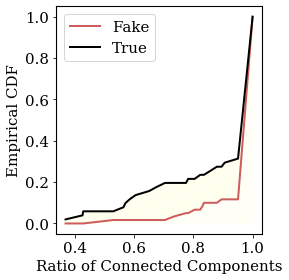

In [12]:
plt.figure(figsize=(4,4))
plt.plot(y, F_f, marker=None, color='indianred', label='Fake', linewidth=2)
plt.fill_between(y, F_f, alpha=0.2, color='lightyellow', hatch='\/')
plt.plot(y, F_t, marker=None, color='black', label='True', linewidth=2)
plt.fill_between(y, F_f, F_t, alpha=0.5, color='lightyellow', hatch='\\', label=None)
print(F_t - F_f)
plt.legend()
plt.xlabel('Ratio of Connected Components')
plt.ylabel('Empirical CDF')
plt.tight_layout()
plt.savefig('dist_prop_cc.pdf')

In [ ]:

# -----------------------------

mean_prop_fake = np.mean(prop_cc[fake_ind])
mean_prop_true = np.mean(prop_cc[true_ind])
print(mean_prop_fake)
print(mean_prop_true)
sample_size_fake = len(fake_ind)
sample_size_true = len(true_ind)
print(sample_size_fake)
print(sample_size_true)
std_prop_fake = np.std(prop_cc[fake_ind])
std_prop_true = np.std(prop_cc[true_ind])
print(std_prop_fake)
print(std_prop_true)
# s2_prop_fake = std_prop_fake ** 2
# s2_prop_true = std_prop_true ** 2
s2_prop_fake = np.sum((prop_cc[fake_ind] - mean_prop_fake) ** 2) / (sample_size_fake-1)
s2_prop_true = np.sum((prop_cc[true_ind] - mean_prop_true) ** 2)/ (sample_size_true-1)
print(s2_prop_fake)
print(s2_prop_true)

t_statistic = (mean_prop_fake - mean_prop_true) / np.sqrt(s2_prop_fake/sample_size_fake + s2_prop_true/sample_size_true)
print(t_statistic)

# The p-value is .003951. (one tail)
# The result is significant at p < .01.

df_num = ((s2_prop_fake/sample_size_fake + s2_prop_true/sample_size_true)) ** 2
df_den = (s2_prop_fake/sample_size_fake) ** 2 / (sample_size_fake-1) + (s2_prop_true/sample_size_true) ** 2 / (sample_size_true-1)
df = df_num / df_den
print(df)

#Aspin-Welch Unequal-Variance T-Test Section

# -----------------------------

f = prop_cc[fake_ind]
t = prop_cc[true_ind]

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.distplot(f)

sns.distplot(t)

# P-Value: Avg Time Delay between Engagements

In [10]:
cascades_file = "../data/tma/cascades.txt"
# links_file = "../../datasets/ma/rel_links.txt"
labels_file = "../data/tma/labels.txt"

# cascades_file = "../data/kwon/cascades.txt"
# # links_file = "../data/ma/rel_links.txt"
# labels_file = "../data/kwon/labels.txt"

import numpy as np
all_cas_users = set()
list_cas = []
f = open(cascades_file, 'r')
for i, line in enumerate(f.readlines()):
    #print(line)
    cas_times = np.array(line.split(',')[1::2], dtype=np.float32)
    cas_users = np.array(line.split(',')[::2], dtype=np.int64)
    list_cas.append((cas_users, cas_times))
    all_cas_users.update(set(cas_users))
#     if i == 3:
#         break
print("done", len(all_cas_users))

mean_gaps = []
cas_lens = []
for cas in list_cas:
    casu, cast = cas[0], cas[1]
    gap = cast[1:] - cast[:-1]
    mean_gaps.append(np.mean(gap)/3600)
    cas_lens.append(len(casu))
# print(mean_gaps)
# print(cas_lens)

# ----------------------------

labels = np.loadtxt(labels_file)
fake_ind = np.where(labels==1)[0]
true_ind = np.where(labels==0)[0]
prop_cc = np.array(np.log(mean_gaps))
# prop_cc = np.array(mean_gaps)
# print(prop_cc)

# print(prop_cc[fake_ind])
# print("\n")
# print(prop_cc[true_ind])

# ----------------------------

mean_prop_fake = np.mean(prop_cc[fake_ind])
mean_prop_true = np.mean(prop_cc[true_ind])

print("max min log fake = ", max(prop_cc[fake_ind]), min(prop_cc[fake_ind]))
print("max min log true = ", max(prop_cc[true_ind]), min(prop_cc[true_ind]))

print("mean log fake=", mean_prop_fake)
print("mean log true= ", mean_prop_true)
sample_size_fake = len(fake_ind)
sample_size_true = len(true_ind)
print("sample size fake=", sample_size_fake)
print("sample size true=", sample_size_true)
std_prop_fake = np.std(prop_cc[fake_ind])
std_prop_true = np.std(prop_cc[true_ind])
# print(std_prop_fake)
# print(std_prop_true)
s2_prop_fake = std_prop_fake ** 2
s2_prop_true = std_prop_true ** 2
# s2_prop_fake = np.sum((prop_cc[fake_ind] - mean_prop_fake) ** 2) / (sample_size_fake-1)
# s2_prop_true = np.sum((prop_cc[true_ind] - mean_prop_true) ** 2)/ (sample_size_true-1)
# print(s2_prop_fake)
# print(s2_prop_true)

t_statistic = (mean_prop_fake - mean_prop_true) / np.sqrt(s2_prop_fake/sample_size_fake + s2_prop_true/sample_size_true)
print("t =", t_statistic)
# denom of t-statistic is std error

# degrees of freedom (i think this is for pooled variance, assuming both have equal variance, so club them for better p-values)
df_num = ((s2_prop_fake/sample_size_fake + s2_prop_true/sample_size_true)) ** 2
df_den = (s2_prop_fake/sample_size_fake) ** 2 / (sample_size_fake-1) + (s2_prop_true/sample_size_true) ** 2 / (sample_size_true-1)
df = df_num / df_den
print('df =', df)

df = min(sample_size_true - 1, sample_size_fake - 1)
print('df =', df)


# LOG NORMAL: KWON/MA: The p-value is < .00001. engagement mean gaps   # .000134.
# log mean fake = 3.612041839638598
# log mean true = 1.8372581654132927
# avg time between engagements is greater in fake news cascades


# Not sure: log (m_true/m_fake) = +- t*stderr [confidence interval]: With 95% confidence, mean fake gap is between 
# X times and Y times of true mean gap. 

# ----------------------------

f = prop_cc[fake_ind]
t = prop_cc[true_ind]


done 233719
max min log fake =  8.020737527148263 -5.086347115831952
max min log true =  7.643611805227445 -4.4391850485138304
mean log fake= 2.2944840897791847
mean log true=  0.5584609886544457
sample size fake= 498
sample size true= 494
t = 12.760732004189768
df = 986.6642516386715
df = 493


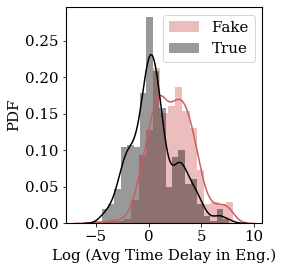

In [11]:
import seaborn as sns
plt.figure(figsize=(4,4))
sns.distplot(f, label='Fake', color='indianred') # , kde='normal')

sns.distplot(t, label='True', color='black') # , kde=False, norm_hist=False)
# plt.savefig('true_cascade_avgengtime.png')
plt.xlabel('Log (Avg Time Delay in Eng.)')
plt.ylabel('PDF')
plt.legend()
plt.tight_layout()
plt.savefig('logavgengtime_tma.pdf')


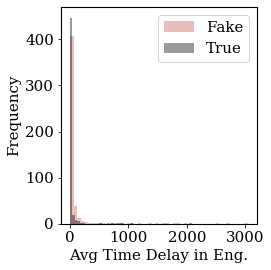

In [12]:
import seaborn as sns
plt.figure(figsize=(4,4))
sns.distplot(np.exp(f), label='Fake', color='indianred', kde=False) # , kde='normal')

sns.distplot(np.exp(t), label='True', color='black', kde=False)
plt.xlabel('Avg Time Delay in Eng.')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('avgengtime_tma.png')
